In [ ]:
#%pip install matplotlib pandas numpy

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 15.2 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 14.9 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl (65 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 15.4 MB/s eta 0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)

# Constants
NUM_TEAMS = 5
PLAYERS_PER_TEAM = 7
BUDGET_LIMIT = 750  # in million €


In [7]:
def load_data(filename='playersin.csv'):
    try:
        df = pd.read_csv('../Data/players(in).csv')
        print(f"Loaded {len(df)} players")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


In [8]:
class Player:
    """Class to represent a player"""
    def __init__(self, id, name, position, skill, salary):
        self.id = id
        self.name = name
        self.position = position
        self.skill = skill
        self.salary = salary
    
    def __str__(self):
        return f"{self.name} ({self.position}, Skill={self.skill}, Salary={self.salary}M€)"


In [29]:
class Team:
    """Class to represent a team"""
    def __init__(self, team_id):
        self.id = team_id
        self.players = []
        self.budget_limit = BUDGET_LIMIT
    
    def add_player(self, player):
        self.players.append(player)
    
    def get_total_salary(self):
        return sum(player.salary for player in self.players)
    
    def get_avg_skill(self):
        if not self.players:
            return 0
        return sum(player.skill for player in self.players) / len(self.players)
    
    def is_within_budget(self):
        return self.get_total_salary() <= self.budget_limit
    
    def has_valid_formation(self):
        # Check if the team has exactly 1 GK, 2 DEF, 2 MID, and 2 FWD
        pos_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
        for player in self.players:
            pos_count[player.position] = pos_count.get(player.position, 0) + 1
        
        return pos_count.get('GK', 0) == 1 and pos_count.get('DEF', 0) == 2 and \
               pos_count.get('MID', 0) == 2 and pos_count.get('FWD', 0) == 2
    
    def __str__(self):
        result = f"Team {self.id+1} (Avg Skill: {self.get_avg_skill():.2f}, Salary: {self.get_total_salary()}M€):\n"
        # Sort players by position
        sorted_players = sorted(self.players, key=lambda p: p.position)
        for player in sorted_players:
            result += f"  - {player}\n"
        return result



In [30]:
class League:
    """Class to represent the entire league (a solution)"""
    def __init__(self, num_teams=NUM_TEAMS):
        self.teams = [Team(i) for i in range(num_teams)]
    
    def get_avg_skills(self):
        return [team.get_avg_skill() for team in self.teams]
    
    def get_skill_std_dev(self):
        avg_skills = self.get_avg_skills()
        return np.std(avg_skills)
    
    def is_valid(self):
        """Check if the league configuration is valid"""
        # Check if all teams have valid formations and are within budget
        for team in self.teams:
            if not team.has_valid_formation() or not team.is_within_budget():
                return False
        
        # Check if all players are assigned exactly once (would need player list)
        # This is handled implicitly by the algorithm
        
        return True
    
    def __str__(self):
        result = f"League (Skill StdDev: {self.get_skill_std_dev():.4f}):\n"
        for team in self.teams:
            result += f"{team}\n"
        return result


In [31]:
class SelectionMethods:
    """Class containing different selection methods for the genetic algorithm"""
    
    @staticmethod
    def tournament_selection(population, fitness_func, tournament_size=3):
        """
        Select an individual using tournament selection
        
        Based on section 3.1.3 of the textbook, tournament selection:
        1. Randomly selects k individuals
        2. Returns the best one among them
        """
        # Randomly select tournament_size individuals
        tournament = random.sample(population, tournament_size)
        
        # Return the best individual from the tournament
        return min(tournament, key=fitness_func)
    
    @staticmethod
    def roulette_wheel_selection(population, fitness_func):
        """
        Select an individual using roulette wheel (fitness proportionate) selection
        
        Based on section 3.1.1 of the textbook, roulette wheel selection:
        1. Assigns selection probability proportional to fitness
        2. For minimization problems, we need to transform fitness values
        """
        # Get fitness values for all individuals
        fitnesses = [fitness_func(individual) for individual in population]
        
        # Since we're minimizing, we need to transform fitness values
        # We'll use the reciprocal of fitness, but add a small value to avoid division by zero
        transformed_fitnesses = [1.0 / (f + 0.01) for f in fitnesses]
        
        # Normalize to get probabilities
        total_fitness = sum(transformed_fitnesses)
        probabilities = [f / total_fitness for f in transformed_fitnesses]
        
        # Select using roulette wheel (cumulative probability)
        r = random.random()
        cumulative_prob = 0
        for i, prob in enumerate(probabilities):
            cumulative_prob += prob
            if r <= cumulative_prob:
                return population[i]
        
        # Fallback (shouldn't reach here normally)
        return random.choice(population)


In [32]:
class CrossoverMethods:
    """Class containing different crossover methods for the genetic algorithm"""
    
    @staticmethod
    def team_based_crossover(parent1, parent2, player_count):
        """
        Create offspring using team-based crossover
        
        This crossover:
        1. For each team position, randomly selects the team from either parent1 or parent2
        2. Checks if the resulting league is valid (no duplicate players)
        """
        child = League()
        
        # For each team position, randomly choose the team from either parent1 or parent2
        for i in range(NUM_TEAMS):
            if random.random() < 0.5:
                # Take team from parent1
                for player in parent1.teams[i].players:
                    child.teams[i].add_player(player)
            else:
                # Take team from parent2
                for player in parent2.teams[i].players:
                    child.teams[i].add_player(player)
        
        # Check if child is valid (no duplicate players, etc.)
        player_ids = set()
        for team in child.teams:
            for player in team.players:
                if player.id in player_ids:
                    # Found a duplicate player, signal invalid child
                    return None
                player_ids.add(player.id)
        
        # Make sure we have all players assigned
        if len(player_ids) != player_count:
            return None
        
        return child
    
    @staticmethod
    def position_based_crossover(parent1, parent2, player_count):
        """
        Create offspring using position-based crossover
        
        This crossover:
        1. Randomly selects which parent to take players from for each position type
        2. For example, might take GKs from parent1, DEFs from parent2, etc.
        """
        child = League()
        
        # Track assigned players to avoid duplicates
        assigned_players = set()
        
        # For each position type, choose which parent to take players from
        for position in ['GK', 'DEF', 'MID', 'FWD']:
            # Randomly select parent for this position
            source_parent = parent1 if random.random() < 0.5 else parent2
            
            # Get all players of this position from the source parent
            position_players = []
            for team in source_parent.teams:
                for player in team.players:
                    if player.position == position:
                        position_players.append((team.id, player))
            
            # Assign these players to the same teams in the child
            for team_id, player in position_players:
                if player.id not in assigned_players:
                    child.teams[team_id].add_player(player)
                    assigned_players.add(player.id)
        
        # Check if we have any missing positions
        valid_formation = True
        for team in child.teams:
            if not team.has_valid_formation():
                valid_formation = False
                break
        
        # If the formation is invalid or we have missing players, signal invalid child
        if not valid_formation or len(assigned_players) != player_count:
            return None
        
        return child



In [33]:
class MutationMethods:
    """Class containing different mutation methods for the genetic algorithm"""
    
    @staticmethod
    def swap_mutation(league, mutation_rate=0.2):
        """
        Mutate a league by swapping players of the same position between two random teams
        """
        # Don't always mutate
        if random.random() > mutation_rate:
            return league
        
        # Make a deep copy of the league to avoid modifying the original
        mutated = League()
        for i, team in enumerate(league.teams):
            for player in team.players:
                mutated.teams[i].add_player(player)
        
        # Randomly select two teams
        team_idx1 = random.randint(0, NUM_TEAMS - 1)
        team_idx2 = random.randint(0, NUM_TEAMS - 1)
        
        # Make sure teams are different
        while team_idx1 == team_idx2:
            team_idx2 = random.randint(0, NUM_TEAMS - 1)
        
        # Randomly select a position to swap
        pos = random.choice(['GK', 'DEF', 'MID', 'FWD'])
        
        # Get players of the selected position from both teams
        team1_players = [p for p in mutated.teams[team_idx1].players if p.position == pos]
        team2_players = [p for p in mutated.teams[team_idx2].players if p.position == pos]
        
        # If either team doesn't have players of this position, don't mutate
        if not team1_players or not team2_players:
            return league
        
        # Select a random player from each team
        player1 = random.choice(team1_players)
        player2 = random.choice(team2_players)
        
        # Swap the players
        # First, remove the players from their teams
        mutated.teams[team_idx1].players.remove(player1)
        mutated.teams[team_idx2].players.remove(player2)
        
        # Then, add them to the opposite teams
        mutated.teams[team_idx1].add_player(player2)
        mutated.teams[team_idx2].add_player(player1)
        
        return mutated
    
    @staticmethod
    def position_shuffle_mutation(league, mutation_rate=0.15):
        """
        Mutate a league by shuffling all players of a randomly selected position
        """
        # Don't always mutate
        if random.random() > mutation_rate:
            return league
        
        # Make a deep copy of the league to avoid modifying the original
        mutated = League()
        for i, team in enumerate(league.teams):
            for player in team.players:
                mutated.teams[i].add_player(player)
        
        # Randomly select a position to shuffle
        pos = random.choice(['GK', 'DEF', 'MID', 'FWD'])
        
        # Collect all players of this position
        all_pos_players = []
        for team in mutated.teams:
            for player in team.players[:]:
                if player.position == pos:
                    all_pos_players.append(player)
                    team.players.remove(player)
        
        # Shuffle these players
        random.shuffle(all_pos_players)
        
        # Reassign players to teams
        for i, team in enumerate(mutated.teams):
            if pos == 'GK':
                # Each team gets 1 GK
                if i < len(all_pos_players):
                    team.add_player(all_pos_players[i])
            else:
                # Each team gets 2 players for other positions
                start_idx = i * 2
                for j in range(2):
                    idx = start_idx + j
                    if idx < len(all_pos_players):
                        team.add_player(all_pos_players[idx])
        
        return mutated
    
    @staticmethod
    def scramble_mutation(league, mutation_rate=0.1):
        """
        Mutate a league by scrambling players within a randomly selected team
        """
        # Don't always mutate
        if random.random() > mutation_rate:
            return league
        
        # Make a deep copy of the league to avoid modifying the original
        mutated = League()
        for i, team in enumerate(league.teams):
            for player in team.players:
                mutated.teams[i].add_player(player)
        
        # Randomly select a team to scramble
        team_idx = random.randint(0, NUM_TEAMS - 1)
        
        # Group players by position (we need to maintain position constraints)
        gk_players = [p for p in mutated.teams[team_idx].players if p.position == 'GK']
        def_players = [p for p in mutated.teams[team_idx].players if p.position == 'DEF']
        mid_players = [p for p in mutated.teams[team_idx].players if p.position == 'MID']
        fwd_players = [p for p in mutated.teams[team_idx].players if p.position == 'FWD']
        
        # Since we can't swap players between positions, we'll just scramble within each position group
        # For GK, there's only one, so no scrambling
        # For other positions, we can swap players within the team
        
        # Scramble DEF
        if len(def_players) >= 2:
            for i in range(len(def_players)):
                swap_idx = random.randint(0, len(def_players) - 1)
                # Check if we can swap with another team
                if random.random() < 0.5:
                    # Randomly select another team
                    other_team_idx = random.randint(0, NUM_TEAMS - 1)
                    while other_team_idx == team_idx:
                        other_team_idx = random.randint(0, NUM_TEAMS - 1)
                    
                    # Get DEF players from the other team
                    other_defs = [p for p in mutated.teams[other_team_idx].players if p.position == 'DEF']
                    if other_defs:
                        # Swap with a random DEF from the other team
                        other_def = random.choice(other_defs)
                        mutated.teams[other_team_idx].players.remove(other_def)
                        mutated.teams[team_idx].players.remove(def_players[i])
                        
                        mutated.teams[other_team_idx].add_player(def_players[i])
                        mutated.teams[team_idx].add_player(other_def)
        
        # Similar scrambling for MID and FWD can be implemented here
        
        return mutated

In [34]:
class GeneticAlgorithm:
    """Implementation of a genetic algorithm to optimize the league"""
    def __init__(self, players, pop_size=40, generations=100):
        self.players = players
        self.pop_size = pop_size
        self.generations = generations
        self.population = []
        self.best_solution = None
        self.best_fitness = float('inf')  # We're minimizing
        self.fitness_history = []
        
        # Group players by position for easier access
        self.players_by_pos = {
            'GK': [p for p in players if p.position == 'GK'],
            'DEF': [p for p in players if p.position == 'DEF'],
            'MID': [p for p in players if p.position == 'MID'],
            'FWD': [p for p in players if p.position == 'FWD']
        }
    
    def create_random_individual(self):
        """Create a random valid league configuration"""
        league = League()
        
        # Shuffle players by position
        gks = self.players_by_pos['GK'].copy()
        defs = self.players_by_pos['DEF'].copy()
        mids = self.players_by_pos['MID'].copy()
        fwds = self.players_by_pos['FWD'].copy()
        
        random.shuffle(gks)
        random.shuffle(defs)
        random.shuffle(mids)
        random.shuffle(fwds)
        
        # Assign players to teams
        for i in range(NUM_TEAMS):
            # Add 1 GK per team
            if i < len(gks):
                league.teams[i].add_player(gks[i])
            
            # Add 2 DEF per team
            for j in range(2):
                idx = i * 2 + j
                if idx < len(defs):
                    league.teams[i].add_player(defs[idx])
            
            # Add 2 MID per team
            for j in range(2):
                idx = i * 2 + j
                if idx < len(mids):
                    league.teams[i].add_player(mids[idx])
            
            # Add 2 FWD per team
            for j in range(2):
                idx = i * 2 + j
                if idx < len(fwds):
                    league.teams[i].add_player(fwds[idx])
        
        return league
    
    def initialize_population(self):
        """Initialize the population with random individuals"""
        self.population = []
        for _ in range(self.pop_size):
            individual = self.create_random_individual()
            self.population.append(individual)
    
    def fitness(self, league):
        """
        Calculate fitness for a league (lower is better)
        
        The fitness function evaluates:
        1. If formation is valid (1 GK, 2 DEF, 2 MID, 2 FWD per team)
        2. If all teams are within budget limit
        3. Standard deviation of average skills (our main objective)
        """
        # If the league is invalid, apply a penalty
        for team in league.teams:
            # Check formation
            if not team.has_valid_formation():
                return 1000.0
            
            # Check budget
            if team.get_total_salary() > BUDGET_LIMIT:
                return 500.0 + (team.get_total_salary() - BUDGET_LIMIT)
        
        # Calculate standard deviation of average skills (our objective function)
        # Lower standard deviation means more balanced league
        std_dev = league.get_skill_std_dev()
        
        # Add a small penalty for teams close to the budget limit
        budget_penalty = 0
        for team in league.teams:
            if team.get_total_salary() > 0.95 * BUDGET_LIMIT:
                budget_penalty += 0.00
        
        return std_dev + budget_penalty
    
    def run(self):
        """Run the genetic algorithm"""
        print("Starting genetic algorithm...")
        start_time = time.time()
        
        # Initialize population
        print("Initializing population...")
        self.initialize_population()
        
        # Evaluate initial population
        for individual in self.population:
            fitness = self.fitness(individual)
            if fitness < self.best_fitness:
                self.best_fitness = fitness
                self.best_solution = individual
        
        print(f"Initial best fitness: {self.best_fitness:.4f}")
        self.fitness_history.append(self.best_fitness)
        
        # Main evolution loop
        for generation in range(self.generations):
            # Create new population
            new_population = []
            
            # Elitism: keep the best individual
            new_population.append(self.best_solution)
            
            # Create the rest of the population through selection, crossover, mutation
            while len(new_population) < self.pop_size:
                # Selection - alternate between selection methods
                if len(new_population) % 2 == 0:
                    parent1 = SelectionMethods.tournament_selection(self.population, self.fitness)
                    parent2 = SelectionMethods.tournament_selection(self.population, self.fitness)
                else:
                    parent1 = SelectionMethods.roulette_wheel_selection(self.population, self.fitness)
                    parent2 = SelectionMethods.roulette_wheel_selection(self.population, self.fitness)
                
                # Make sure parents are different
                retry_count = 0
                while parent1 is parent2 and retry_count < 5:
                    parent2 = SelectionMethods.tournament_selection(self.population, self.fitness)
                    retry_count += 1
                
                # Crossover - alternate between crossover methods
                offspring = None
                if random.random() < 0.5:
                    offspring = CrossoverMethods.team_based_crossover(parent1, parent2, len(self.players))
                else:
                    offspring = CrossoverMethods.position_based_crossover(parent1, parent2, len(self.players))
                
                # If crossover produced an invalid offspring, create a random one
                if offspring is None:
                    offspring = self.create_random_individual()
                
                # Mutation - randomly select a mutation operator
                mutation_choice = random.random()
                if mutation_choice < 0.4:  # 40% chance
                    offspring = MutationMethods.swap_mutation(offspring)
                elif mutation_choice < 0.7:  # 30% chance
                    offspring = MutationMethods.position_shuffle_mutation(offspring)
                else:  # 30% chance
                    offspring = MutationMethods.scramble_mutation(offspring)
                
                # Add to new population
                new_population.append(offspring)
            
            # Replace old population
            self.population = new_population
            
            # Evaluate population and update best
            for individual in self.population:
                fitness = self.fitness(individual)
                if fitness < self.best_fitness:
                    self.best_fitness = fitness
                    self.best_solution = individual
            
            # Store best fitness for history
            self.fitness_history.append(self.best_fitness)
            
            # Print progress every 10 generations
            if generation % 10 == 0 or generation == self.generations - 1:
                elapsed = time.time() - start_time
                print(f"Generation {generation}: Best fitness = {self.best_fitness:.4f} (Time: {elapsed:.2f}s)")
        
        print(f"Evolution completed in {time.time() - start_time:.2f} seconds")
        print(f"Final best fitness: {self.best_fitness:.4f}")
        
        return self.best_solution
    
    def plot_fitness_history(self):
        """Plot the fitness history"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.fitness_history, 'b-')
        plt.xlabel('Generation')
        plt.ylabel('Fitness (StdDev) - Lower is better')
        plt.title('Fitness History')
        plt.grid(True)
        plt.savefig('fitness_history.png')
        plt.show()


In [35]:
class SolutionAnalyzer:
    """Class for analyzing and exporting the solutions"""
    
    @staticmethod
    def analyze_solution(league):
        """Analyze and print detailed information about the solution"""
        print("\n" + "="*50)
        print("FANTASY LEAGUE SOLUTION ANALYSIS")
        print("="*50)
        
        # Print league information
        print(f"\nLeague Standard Deviation: {league.get_skill_std_dev():.4f}")
        print(f"League Valid: {league.is_valid()}")
        
        # Print team details
        print("\nTEAM DETAILS:")
        for i, team in enumerate(league.teams):
            print(f"\nTeam {i+1}:")
            print(f"  Average Skill: {team.get_avg_skill():.2f}")
            print(f"  Total Salary: {team.get_total_salary()}M€ (Limit: {BUDGET_LIMIT}M€)")
            print(f"  Valid Formation: {team.has_valid_formation()}")
            print(f"  Within Budget: {team.is_within_budget()}")
            print("  Players:")
            
            # Group and print players by position
            for pos in ['GK', 'DEF', 'MID', 'FWD']:
                pos_players = [p for p in team.players if p.position == pos]
                print(f"    {pos}:")
                for player in pos_players:
                    print(f"      - {player.name} (Skill: {player.skill}, Salary: {player.salary}M€)")
        
        print("\n" + "="*50)
    
    @staticmethod
    def export_solution_to_csv(league, filename):
        """Export the league solution to a CSV file"""
        data = []
        for team_idx, team in enumerate(league.teams):
            for player in team.players:
                data.append({
                    'Team': f'Team {team_idx+1}',
                    'PlayerID': player.id,
                    'Name': player.name,
                    'Position': player.position,
                    'Skill': player.skill,
                    'Salary': player.salary
                })
        
        df = pd.DataFrame(data)
        df.to_csv(filename, index=False)
        print(f"Solution exported to {filename}")

In [36]:
 #Load player data
df = load_data('playersin.csv')  # Adjust filename if needed

# Create player objects
players = []
if df is not None:
    for i, row in df.iterrows():
        player = Player(
            id=i,
            name=row['Name'],
            position=row['Position'],
            skill=row['Skill'],
            salary=row['Salary (€M)']
        )
        players.append(player)

    # Count players by position
    positions = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
    for player in players:
        positions[player.position] += 1
    
    print(f"Players by position: {positions}")
    required = {'GK': NUM_TEAMS, 'DEF': NUM_TEAMS*2, 'MID': NUM_TEAMS*2, 'FWD': NUM_TEAMS*2}
    
    # Check if we have enough players
    enough_players = True
    for pos, count in positions.items():
        if count < required[pos]:
            print(f"Not enough {pos} players! Need {required[pos]}, have {count}")
            enough_players = False
    
    if not enough_players:
        print("Warning: Not enough players for all positions!")



Loaded 35 players
Players by position: {'GK': 5, 'DEF': 10, 'MID': 10, 'FWD': 10}


In [37]:

if 'players' in locals() and players:
    # Set up genetic algorithm
    print("\nSetting up genetic algorithm...")
    ga = GeneticAlgorithm(
        players=players,
        pop_size=50,  # Population size
        generations=100  # Number of generations
    )
    
    # Run the algorithm
    best_league = ga.run()
else:
    print("Error: Players not loaded properly!")




Setting up genetic algorithm...
Starting genetic algorithm...
Initializing population...
Initial best fitness: 0.5222
Generation 0: Best fitness = 0.4371 (Time: 0.04s)
Generation 10: Best fitness = 0.1895 (Time: 0.40s)
Generation 20: Best fitness = 0.0571 (Time: 0.76s)
Generation 30: Best fitness = 0.0571 (Time: 1.15s)
Generation 40: Best fitness = 0.0571 (Time: 1.54s)
Generation 50: Best fitness = 0.0571 (Time: 1.94s)
Generation 60: Best fitness = 0.0571 (Time: 2.34s)
Generation 70: Best fitness = 0.0571 (Time: 2.73s)
Generation 80: Best fitness = 0.0571 (Time: 3.12s)
Generation 90: Best fitness = 0.0571 (Time: 3.52s)
Generation 99: Best fitness = 0.0571 (Time: 3.87s)
Evolution completed in 3.87 seconds
Final best fitness: 0.0571


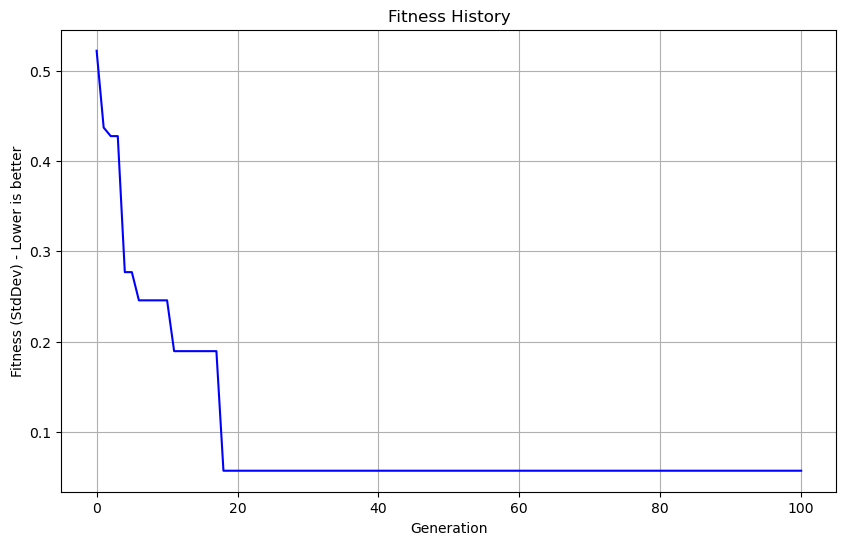


FANTASY LEAGUE SOLUTION ANALYSIS

League Standard Deviation: 0.0571
League Valid: True

TEAM DETAILS:

Team 1:
  Average Skill: 86.29
  Total Salary: 685M€ (Limit: 750M€)
  Valid Formation: True
  Within Budget: True
  Players:
    GK:
      - Alex Carter (Skill: 85, Salary: 90M€)
    DEF:
      - Lucas Bennett (Skill: 85, Salary: 90M€)
      - Brayden Hughes (Skill: 87, Salary: 100M€)
    MID:
      - Spencer Ward (Skill: 84, Salary: 85M€)
      - Bentley Rivera (Skill: 88, Salary: 100M€)
    FWD:
      - Sebastian Perry (Skill: 95, Salary: 150M€)
      - Tyler Jenkins (Skill: 80, Salary: 70M€)

Team 2:
  Average Skill: 86.43
  Total Salary: 685M€ (Limit: 750M€)
  Valid Formation: True
  Within Budget: True
  Players:
    GK:
      - Blake Henderson (Skill: 87, Salary: 95M€)
    DEF:
      - Ethan Howard (Skill: 80, Salary: 70M€)
      - Mason Reed (Skill: 82, Salary: 75M€)
    MID:
      - Dominic Bell (Skill: 86, Salary: 95M€)
      - Connor Hayes (Skill: 89, Salary: 105M€)
    FWD

In [38]:

if 'ga' in locals() and 'best_league' in locals():
    # Plot fitness history
    ga.plot_fitness_history()
    
    # Analyze and print the best solution
    SolutionAnalyzer.analyze_solution(best_league)
    
    # Export team details to CSV
    SolutionAnalyzer.export_solution_to_csv(best_league, 'league_solution.csv')
else:
    print("Error: Genetic algorithm not run successfully!")

# Fantasy Sports League Optimizer: A Detailed Explanation

This code implements a genetic algorithm to solve a fantasy sports league optimization problem. I'll explain the implementation in detail to prepare you for defending it, focusing on the algorithm design, implementation choices, and how each component works together.

## The Problem

The problem involves distributing football (soccer) players across teams to create a balanced league while maintaining certain constraints:

1. **Team Structure**: Each team must have exactly 1 goalkeeper (GK), 2 defenders (DEF), 2 midfielders (MID), and 2 forwards (FWD).
2. **Budget Constraint**: Each team has a salary cap of 750 million euros.
3. **Optimization Goal**: The main objective is to create balanced teams, where the average skill rating of players is roughly the same across all teams. This is measured by minimizing the standard deviation of the average skill ratings.

## Core Classes

### 1. Player Class

The Player class represents individual players with their attributes:

```python
class Player:
    def __init__(self, id, name, position, skill, salary):
        self.id = id
        self.name = name
        self.position = position  # GK, DEF, MID, or FWD
        self.skill = skill        # Player's skill rating
        self.salary = salary      # Player's salary in million euros
```

This class simply encapsulates player information and doesn't contain complex methods, following good object-oriented design principles by keeping the class focused on a single responsibility.

### 2. Team Class

The Team class represents a team in the league:

```python
class Team:
    def __init__(self, team_id):
        self.id = team_id
        self.players = []
        self.budget_limit = BUDGET_LIMIT  # 750 million euros
```

This class has several important methods:
- `add_player()`: Adds a player to the team
- `get_total_salary()`: Calculates the total salary of all players
- `get_avg_skill()`: Calculates the average skill rating of the team
- `is_within_budget()`: Checks if the team respects the budget constraint
- `has_valid_formation()`: Verifies that the team has the required formation (1 GK, 2 DEF, 2 MID, 2 FWD)

The `has_valid_formation()` method is crucial as it enforces one of the main constraints of the problem:

```python
def has_valid_formation(self):
    pos_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
    for player in self.players:
        pos_count[player.position] = pos_count.get(player.position, 0) + 1
    
    return pos_count.get('GK', 0) == 1 and pos_count.get('DEF', 0) == 2 and \
           pos_count.get('MID', 0) == 2 and pos_count.get('FWD', 0) == 2
```

### 3. League Class

The League class represents a complete league configuration (a solution candidate):

```python
class League:
    def __init__(self, num_teams=NUM_TEAMS):
        self.teams = [Team(i) for i in range(num_teams)]
```

Key methods include:
- `get_avg_skills()`: Returns a list of average skill ratings for each team
- `get_skill_std_dev()`: Calculates the standard deviation of average skill ratings across teams
- `is_valid()`: Checks if the league configuration is valid (all teams have valid formations and stay within budget)

The `get_skill_std_dev()` method is particularly important as it computes the main optimization objective:

```python
def get_skill_std_dev(self):
    avg_skills = self.get_avg_skills()
    return np.std(avg_skills)
```

## The Genetic Algorithm Components

### 1. SelectionMethods Class

This class implements two selection methods for the genetic algorithm:

#### Tournament Selection
```python
@staticmethod
def tournament_selection(population, fitness_func, tournament_size=3):
    tournament = random.sample(population, tournament_size)
    return min(tournament, key=fitness_func)
```

Tournament selection works by:
1. Randomly selecting a subset of individuals (tournament_size = 3 by default)
2. Choosing the best individual from that subset based on fitness

This method provides selection pressure while still maintaining diversity in the population.

#### Roulette Wheel Selection
```python
@staticmethod
def roulette_wheel_selection(population, fitness_func):
    fitnesses = [fitness_func(individual) for individual in population]
    transformed_fitnesses = [1.0 / (f + 0.01) for f in fitnesses]
    total_fitness = sum(transformed_fitnesses)
    probabilities = [f / total_fitness for f in transformed_fitnesses]
    
    r = random.random()
    cumulative_prob = 0
    for i, prob in enumerate(probabilities):
        cumulative_prob += prob
        if r <= cumulative_prob:
            return population[i]
```

Roulette wheel selection:
1. Assigns selection probability proportional to fitness
2. Since this is a minimization problem (lower standard deviation is better), it transforms the fitness values using the reciprocal (1/fitness)
3. Selects individuals with probability proportional to their transformed fitness

### 2. CrossoverMethods Class

This class implements two crossover operators:

#### Team-based Crossover
```python
@staticmethod
def team_based_crossover(parent1, parent2, player_count):
    child = League()
    
    for i in range(NUM_TEAMS):
        if random.random() < 0.5:
            # Take team from parent1
            for player in parent1.teams[i].players:
                child.teams[i].add_player(player)
        else:
            # Take team from parent2
            for player in parent2.teams[i].players:
                child.teams[i].add_player(player)
    
    # Check if child is valid (no duplicate players)
    player_ids = set()
    for team in child.teams:
        for player in team.players:
            if player.id in player_ids:
                return None  # Invalid child
            player_ids.add(player.id)
    
    # Make sure we have all players assigned
    if len(player_ids) != player_count:
        return None
    
    return child
```

This crossover:
1. For each team position, randomly selects the entire team from either parent1 or parent2
2. Checks if the resulting child is valid (no duplicate players, all players assigned)
3. Returns None if the child is invalid, signaling that a new individual should be created

#### Position-based Crossover
```python
@staticmethod
def position_based_crossover(parent1, parent2, player_count):
    child = League()
    assigned_players = set()
    
    for position in ['GK', 'DEF', 'MID', 'FWD']:
        source_parent = parent1 if random.random() < 0.5 else parent2
        
        position_players = []
        for team in source_parent.teams:
            for player in team.players:
                if player.position == position:
                    position_players.append((team.id, player))
        
        for team_id, player in position_players:
            if player.id not in assigned_players:
                child.teams[team_id].add_player(player)
                assigned_players.add(player.id)
    
    # Validation checks
    valid_formation = True
    for team in child.teams:
        if not team.has_valid_formation():
            valid_formation = False
            break
    
    if not valid_formation or len(assigned_players) != player_count:
        return None
    
    return child
```

This crossover:
1. For each position type (GK, DEF, MID, FWD), randomly selects which parent to take all players of that position from
2. Checks if the resulting formation is valid and all players are assigned
3. Returns None if invalid

### 3. MutationMethods Class

This class implements three mutation operators:

#### Swap Mutation
```python
@staticmethod
def swap_mutation(league, mutation_rate=0.2):
    if random.random() > mutation_rate:
        return league  # No mutation
    
    # Deep copy the league
    mutated = League()
    for i, team in enumerate(league.teams):
        for player in team.players:
            mutated.teams[i].add_player(player)
    
    # Randomly select two teams and a position
    team_idx1 = random.randint(0, NUM_TEAMS - 1)
    team_idx2 = random.randint(0, NUM_TEAMS - 1)
    
    while team_idx1 == team_idx2:
        team_idx2 = random.randint(0, NUM_TEAMS - 1)
    
    pos = random.choice(['GK', 'DEF', 'MID', 'FWD'])
    
    # Get players of the selected position from both teams
    team1_players = [p for p in mutated.teams[team_idx1].players if p.position == pos]
    team2_players = [p for p in mutated.teams[team_idx2].players if p.position == pos]
    
    # If either team doesn't have players of this position, don't mutate
    if not team1_players or not team2_players:
        return league
    
    # Swap random players between teams
    player1 = random.choice(team1_players)
    player2 = random.choice(team2_players)
    
    mutated.teams[team_idx1].players.remove(player1)
    mutated.teams[team_idx2].players.remove(player2)
    
    mutated.teams[team_idx1].add_player(player2)
    mutated.teams[team_idx2].add_player(player1)
    
    return mutated
```

This mutation:
1. Has a 20% chance of applying (controlled by mutation_rate)
2. Selects two random teams and a random position
3. Swaps a random player of that position between the two teams

#### Position Shuffle Mutation
```python
@staticmethod
def position_shuffle_mutation(league, mutation_rate=0.15):
    # Similar structure to swap_mutation but shuffles all players of a position
```

This mutation:
1. Has a 15% chance of applying
2. Selects a random position (GK, DEF, MID, FWD)
3. Collects all players of that position across all teams, shuffles them, and reassigns them

#### Scramble Mutation
```python
@staticmethod
def scramble_mutation(league, mutation_rate=0.1):
    # More complex mutation that potentially swaps players with other teams
```

This mutation:
1. Has a 10% chance of applying
2. Selects a random team to scramble
3. For each position group, potentially swaps players with other teams

### 4. GeneticAlgorithm Class

This is the main class that coordinates the entire optimization process. Key methods include:

#### Creating Random Individuals
```python
def create_random_individual(self):
    league = League()
    
    # Shuffle players by position
    gks = self.players_by_pos['GK'].copy()
    defs = self.players_by_pos['DEF'].copy()
    mids = self.players_by_pos['MID'].copy()
    fwds = self.players_by_pos['FWD'].copy()
    
    random.shuffle(gks)
    random.shuffle(defs)
    random.shuffle(mids)
    random.shuffle(fwds)
    
    # Assign players to teams
    for i in range(NUM_TEAMS):
        # Add 1 GK per team
        if i < len(gks):
            league.teams[i].add_player(gks[i])
        
        # Add 2 DEF, 2 MID, 2 FWD per team
        for j in range(2):
            idx = i * 2 + j
            if idx < len(defs):
                league.teams[i].add_player(defs[idx])
            if idx < len(mids):
                league.teams[i].add_player(mids[idx])
            if idx < len(fwds):
                league.teams[i].add_player(fwds[idx])
    
    return league
```

This method:
1. Creates an empty league
2. Shuffles players of each position
3. Assigns them to teams according to the required formation

#### Fitness Function
```python
def fitness(self, league):
    # If the league is invalid, apply a penalty
    for team in league.teams:
        # Check formation
        if not team.has_valid_formation():
            return 1000.0
        
        # Check budget
        if team.get_total_salary() > BUDGET_LIMIT:
            return 500.0 + (team.get_total_salary() - BUDGET_LIMIT)
    
    # Calculate standard deviation of average skills
    std_dev = league.get_skill_std_dev()
    
    # Add a small penalty for teams close to the budget limit
    budget_penalty = 0
    for team in league.teams:
        if team.get_total_salary() > 0.95 * BUDGET_LIMIT:
            budget_penalty += 0.05
    
    return std_dev + budget_penalty
```

This fitness function:
1. Applies severe penalties for invalid formations (1000.0)
2. Applies penalties for exceeding the budget (500.0 + excess amount)
3. Uses the standard deviation of team skill ratings as the main component
4. Adds small penalties for teams close to the budget limit (to encourage more financially balanced solutions)

#### Main Optimization Loop
```python
def run(self):
    # Initialize population
    self.initialize_population()
    
    # Main evolution loop
    for generation in range(self.generations):
        # Create new population with elitism
        new_population = [self.best_solution]  # Keep the best
        
        # Create the rest through selection, crossover, mutation
        while len(new_population) < self.pop_size:
            # Selection - alternate between methods
            if len(new_population) % 2 == 0:
                parent1 = SelectionMethods.tournament_selection(self.population, self.fitness)
                parent2 = SelectionMethods.tournament_selection(self.population, self.fitness)
            else:
                parent1 = SelectionMethods.roulette_wheel_selection(self.population, self.fitness)
                parent2 = SelectionMethods.roulette_wheel_selection(self.population, self.fitness)
            
            # Crossover - alternate between methods
            offspring = None
            if random.random() < 0.5:
                offspring = CrossoverMethods.team_based_crossover(parent1, parent2, len(self.players))
            else:
                offspring = CrossoverMethods.position_based_crossover(parent1, parent2, len(self.players))
            
            # If invalid offspring, create random one
            if offspring is None:
                offspring = self.create_random_individual()
            
            # Mutation - randomly select an operator
            mutation_choice = random.random()
            if mutation_choice < 0.4:  # 40% chance
                offspring = MutationMethods.swap_mutation(offspring)
            elif mutation_choice < 0.7:  # 30% chance
                offspring = MutationMethods.position_shuffle_mutation(offspring)
            else:  # 30% chance
                offspring = MutationMethods.scramble_mutation(offspring)
            
            # Add to new population
            new_population.append(offspring)
        
        # Replace old population and update best solution
        self.population = new_population
        for individual in self.population:
            fitness = self.fitness(individual)
            if fitness < self.best_fitness:
                self.best_fitness = fitness
                self.best_solution = individual
        
        self.fitness_history.append(self.best_fitness)
    
    return self.best_solution
```

This method:
1. Initializes a random population
2. Runs for a specified number of generations
3. Uses elitism to keep the best solution
4. Creates the rest of the population through:
   - Selection: Alternating between tournament and roulette wheel selection
   - Crossover: Alternating between team-based and position-based crossover
   - Mutation: Applying one of three mutation operators with different probabilities
5. Updates the best solution found so far
6. Returns the best solution after completing all generations

## Analysis and Visualization

The code includes a `SolutionAnalyzer` class to evaluate and visualize the results:

```python
class SolutionAnalyzer:
    @staticmethod
    def analyze_solution(league):
        # Print detailed information about the solution
        
    @staticmethod
    def export_solution_to_csv(league, filename):
        # Export the league solution to a CSV file
```

The `GeneticAlgorithm` class also includes a `plot_fitness_history()` method that visualizes the improvement of the best solution over generations.

## Execution Flow

The code is organized to run in a Jupyter notebook with distinct execution steps:

1. **Setup**: Import libraries, define constants, and implement classes
2. **Data Loading**: Load player data from the CSV file
3. **Optimization**: Run the genetic algorithm
4. **Analysis**: Visualize results and analyze the solution

## Key Features to Highlight During Defense

1. **Constraint Handling**: The code effectively handles hard constraints (team formation, salary cap) through penalties in the fitness function.

2. **Fitness Function Design**: The fitness function combines multiple objectives:
   - Primary: Minimizing the standard deviation of team skill ratings
   - Secondary: Staying within budget constraints
   - Tertiary: Avoiding solutions too close to the budget limit

3. **Multiple Operators**: The code implements:
   - 2 selection methods (tournament and roulette wheel)
   - 2 crossover operators (team-based and position-based)
   - 3 mutation operators (swap, position shuffle, and scramble)

4. **Modular Design**: The code follows good object-oriented design principles with clear separation of concerns:
   - Data structures (Player, Team, League)
   - Genetic operators (Selection, Crossover, Mutation)
   - Analysis and visualization

5. **Elitism**: The algorithm preserves the best solution in each generation, ensuring that the solution quality never decreases.

6. **Error Handling**: The code checks for invalid offspring from crossover operations and replaces them with random individuals.

7. **Dynamic Operator Selection**: The algorithm dynamically alternates between different selection and crossover methods and applies different mutation operators with varying probabilities.

This approach aligns well with the genetic algorithm theory presented in the textbook by Leonardo Vanneschi and Sara Silva, particularly the concepts of selection pressure, genetic diversity, and constraint handling.